# Exploring building reference datasets with kerchunk

The idea: build a test intake catalogue of kerchunk virtual dataset(s) from the COSIMA output(s) and see how it performs

In [1]:
%cd /g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake

/g/data/tm70/ds0092/projects/dev_data_querying/cosima_intake


In [2]:
import re
import os
import time
import glob
import datetime

import pandas as pd

import xarray as xr

import fsspec.implementations.reference

# Build a reference dataset for all cycles of `access-om2-025` `025deg_jra55_iaf_omip2` 

**25 TB** of compressed data across **11,385 netcdf4 files** is referenced by **6 parquet files** totalling **884 MB**

I ran these cells with a full broadwell node

## Prepare combined kerchunk reference json

Note I found a bug in `kerchunk.combine.auto_dask`. My fix has now been merged, but I still have issues using `auto_dask` for datasets of this size - workers die and data doesn't get written. Here we'll do things manually.

In [3]:
def create_reference(*single_input, filename, parquet=True, cleanup="all"):
    """
    Create a kerchunk reference file in stages for sets of netcdf4 files. When
    multiple single_inputs are passed, will create reference file for each single_input
    amnd then combine these with kerchunk.combine.merge_vars which assumes coordinates
    and global attributes are identical across the references being combined.
    
    Parameters
    ----------
    single_input: tuple
        Size 2 tuple with the first element containing a list of the netcdf files to be
        combined and the second element containing a dictionary with the kwargs to pass
        to kerchunk.combine.MultiZarrToZarr to combine these files
    filename: str
        The name of the reference file
    parquet: bool
        If True, generate parquet reference file in addition to json
    cleanup: str
        How much of the intermediate reference files to clean up on completion:
            "all": clean up all intermediate files
            "single": clean up single-file reference files
            "none": don't do any clean up
    """
    
    import time
    import shutil
    import dask
    import zarr
    import ujson
    from distributed import Client
    from kerchunk import hdf, combine, df
    
    @dask.delayed
    def _gen_json(ncfile, jsonfile):
        with fs.open(ncfile) as infile:
            h5chunks = hdf.SingleHdf5ToZarr(infile, ncfile)
            with open(jsonfile, 'wb') as f:
                f.write(ujson.dumps(h5chunks.translate()).encode())
    
    if cleanup not in ["all", "single", "none"]:
        raise ValueError("cleanup must be one of 'all', 'single', 'none'")
    
    dirname = os.path.dirname(filename)
    if dirname != "":
        os.makedirs(os.path.dirname(filename), mode=0o775, exist_ok=True)
    filename = filename.strip(".json")
    
    intermediate_jsons = []
    for idx, single in enumerate(single_input):
        ncfiles, mzz_kwargs = single
        
        # Write single file jsons
        single_jsons = []
        tasks = []
        for file in ncfiles:
            single_json = os.path.join(dirname, f"{'.'.join(file.split('/'))}.json")
            single_jsons.append(single_json)
            tasks.append(_gen_json(file, single_json))
            
        with Client(threads_per_worker=1) as client:
            _ = dask.compute(*tasks)
                         
        # Write multi-file json
        intermediate = combine.MultiZarrToZarr(
            single_jsons,
            **mzz_kwargs
        ).translate()
        
        intermediate_json = os.path.join(dirname, f"ref{idx}.json")
        with open(intermediate_json, 'wb') as f:
            f.write(ujson.dumps(intermediate).encode())
        intermediate_jsons.append(intermediate_json)

        if (cleanup == "all") or (cleanup == "single"):            
            for json in single_jsons:
                os.remove(json)
                
    # Combine multifile jsons
    # This assumes coordinates and attributes are the same across intermediates
    combined = combine.merge_vars(
        intermediate_jsons,
    )
    
    unconsolidated_json = os.path.join(dirname, f".{os.path.basename(filename)}.json")
    with open(unconsolidated_json, 'wb') as f:
        f.write(ujson.dumps(combined).encode())
    
    m = fsspec.get_mapper(
        'reference://',
        fo=unconsolidated_json,
        remote_protocol="file"
    )
    zarr.convenience.consolidate_metadata(m)
    m.fs.save_json(f"{filename}.json")

    if parquet:
        parquet_file = f"{filename}.parq"
        if os.path.exists(parquet_file) and os.path.isdir(parquet_file):
            shutil.rmtree(parquet_file)
        os.mkdir(parquet_file)
        df.refs_to_dataframe(combined, parquet_file, partition=True)

    if (cleanup == "all"):
        os.remove(unconsolidated_json)
        for json in intermediate_jsons:
            os.remove(json)

In [4]:
fs = fsspec.filesystem('file')
exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle*"

def get_cycle(index, fs, var, fn):
    return int(re.search(r"cycle(\d+)", fn)[1])

to_kerchunk = {
    # "ocean_month": (
    #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_month.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "xt_ocean", 
    #             "yt_ocean", 
    #             "st_ocean", 
    #             "xu_ocean", 
    #             "yu_ocean", 
    #             "sw_ocean", 
    #             "grid_xt_ocean", 
    #             "grid_yt_ocean", 
    #             "grid_xu_ocean", 
    #             "grid_yu_ocean", 
    #             "potrho", 
    #             "neutral",
    #             "neutralrho_edges",
    #             "nv",
    #             "potrho",
    #             "potrho_edges",
    #             "st_edges_ocean",
    #             "sw_edges_ocean"
    #          ]
    #     )
    # ),

    # "ocean_budget": (
    #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_budget.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "xt_ocean", 
    #             "yt_ocean", 
    #             "st_ocean", 
    #             "xu_ocean", 
    #             "yu_ocean", 
    #             "nv",
    #             "st_edges_ocean",
    #          ]
    #     )
    # ),

    "ocean_scalar": (
        sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_scalar.nc")),
        dict(
            coo_map={"cycle": get_cycle},
            concat_dims=["time", "cycle"],
            identical_dims=["scalar_axis", "nv"]
        )
    ),

    # "ocean_daily": (
    #     sorted(fs.glob(f"{exp_root}/output*/ocean/ocean_daily.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "xt_ocean", 
    #             "yt_ocean", 
    #             "xu_ocean", 
    #             "yu_ocean", 
    #             "nv",
    #          ]
    #     )
    # ),
    
    # "ice_month": (
    #     sorted(fs.glob(f"{exp_root}/output*/ice/OUTPUT/iceh.????-??.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "d2",
    #             "ni", 
    #             "nj", 
    #             "nc", 
    #             "nkice", 
    #             "nksnow",
    #             "nkbio",
    #             "nvertices",
    #          ]
    #     )
    # ),
    
    # "ice_daily": (
    #     sorted(fs.glob(f"{exp_root}/output*/ice/OUTPUT/iceh.????-??-daily.nc")),
    #     dict(
    #         coo_map={"cycle": get_cycle},
    #         concat_dims=["time", "cycle"],
    #         identical_dims=[
    #             "d2",
    #             "ni", 
    #             "nj", 
    #             "nc", 
    #          ]
    #     )
    # ),
}

In [5]:
for filename, single_input in to_kerchunk.items():
    print(f"Kerchunking {filename}...")
    tic = time.perf_counter()
    create_reference(
        single_input,
        filename=f"025deg_jra55_iaf_omip2/{filename}",
        cleanup="all"
    )
    toc = time.perf_counter()
    print(f"   Done in {str(datetime.timedelta(seconds=toc-tic))} (h:m:s)")

Kerchunking ocean_scalar...
   Done in 0:00:14.593958 (h:m:s)


# Example compute on a reference datasets and compare to `open_mfdataset`

In [6]:
from distributed import Client

client = Client(threads_per_worker=1)
client.dashboard_link

'/proxy/8787/status'

## 1. Reference parquet dataset

In [7]:
%%time

m = fsspec.implementations.reference.DFReferenceFileSystem(
    "./025deg_jra55_iaf_omip2/ocean_month.parq", lazy=True
).get_mapper()

ds = xr.open_dataset(
    m,
    engine="zarr",
    backend_kwargs={"consolidated": False},
    use_cftime=True,
    drop_variables=["average_T1", "average_T2"], # Need to work out what's wrong with these
    chunks={"cycle": -1, "xt_ocean": -1, "yt_ocean": -1}
)

CPU times: user 13 s, sys: 2.1 s, total: 15.1 s
Wall time: 14.7 s


In [8]:
%%time

# This compute comprises 733 dask tasks and needs ~1.5GB per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 34.6 s, sys: 7.89 s, total: 42.5 s
Wall time: 2min 24s


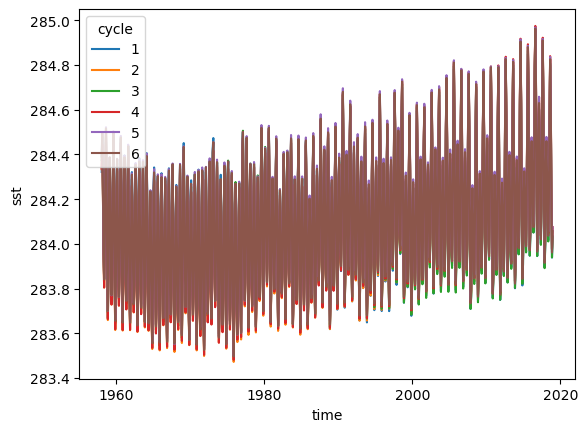

In [9]:
_ = global_mean.plot.line(x="time")

## 2. `open_mfdataset`

In [7]:
%%time

exp_root = "/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle?"

files = []
for cycle in sorted(glob.glob(exp_root)):
    files.append(sorted(glob.glob(f"{cycle}/output*/ocean/ocean_month.nc")))

ds = []
for f in files:
    ds.append(
        xr.open_mfdataset(
            f,
            chunks={
                "cycle": -1,
                "time": 1,
                "yt_ocean": -1,
                "xt_ocean": -1
            }, # Same chunking as reference dataset
            concat_dim="time",
            parallel=True,
            combine="nested",
            data_vars="minimal", 
            coords="minimal", 
            compat="override"
        )
    )
    
ds = xr.concat(ds, dim=pd.Index(range(len(files)), name="cycle"))

CPU times: user 38.4 s, sys: 5.15 s, total: 43.6 s
Wall time: 44.2 s


In [8]:
%%time

# This compute comprises 1830 dask tasks and uses ~700MB of memory per worker
global_mean = ds["sst"].mean(["xt_ocean", "yt_ocean"]).compute()

CPU times: user 13.9 s, sys: 1.11 s, total: 15 s
Wall time: 17.3 s


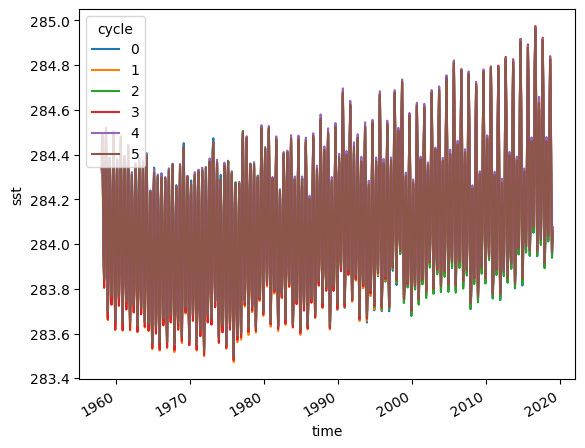

In [9]:
_ = global_mean.plot.line(x="time")

## Notes (some outdated)

- The main impediment to this sort of approach at the moment is that kerchunk references are stored as inefficient json files which can be very large for datasets comprising many chunks. Currently this entire file is loaded with `open_dataset` (and loaded onto each worker when using a distributed cluster) which can require lots of memory and overhead. This outweighs the benefits kerchunk provides in this application (consolidation + zarr simplicity/performance).

- This said, there are a number of things in the kerchunk pipeline that should address the above issue: 1) new data structures for the reference set(s) that facilitate lazy loading (see https://github.com/fsspec/kerchunk/issues/240 and https://github.com/fsspec/kerchunk/issues/134), 2) the ability the split/combine chunks within a reference file but this would have limitations (e.g. couldn't work for particular types of compression, see https://github.com/fsspec/kerchunk/issues/124 and https://github.com/fsspec/kerchunk/issues/134).

- The approach of generating reference datasets for new experiments should be relatively straight-forward if we can have some confidence that all input files will be readily "concatenatable" in the sense that they have the same chunking patterns, coordinates on fixed dims, fixed auxiliary coordinates, variables (where approapriate) etc. The latest functionality for combining references in kerchunk is pretty versatile, see https://fsspec.github.io/kerchunk/tutorial.html#using-coo-map.

- Where the raw data are unchunked (e.g. netcdf3), this approach can significantly impact performance since fsspec will make the full range request even for subsets (https://github.com/fsspec/kerchunk/issues/124).

In [10]:
client.close()